In this notebook you will:

1. Examine and clean **transaction** data  
2. Examine and clean **customer** data  
3. Merge both datasets  
4. Analyse sales and customer segments  
5. Deep dive into segments and save outputs for a report to Bassam

We will work step-by-step in Python using pandas and matplotlib.

**Import libs & upload files**

In [ ]:
# Import essential libraries for data analysis
import pandas as pd  # For data manipulation and analysis (DataFrames)
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For creating visualizations
import re  # For regular expressions (text pattern matching)

**Read Datasets**

In [ ]:
# Load customer purchase behavior data (contains customer segments and loyalty info)
customers = pd.read_csv("/Users/bassamelkoussa/Downloads/vs_code/hal-mvp/day-3/Machine_Learning_Day-1/QVI_purchase_behaviour.csv")

In [ ]:
# Load transaction data (contains all sales transactions with product details)
transactions = pd.read_excel("/Users/bassamelkoussa/Downloads/vs_code/hal-mvp/day-3/Machine_Learning_Day-1/QVI_transaction_data.xlsx")

In [ ]:
# Check the dimensions of the dataset: (rows, columns)
# This tells us how many transactions and how many features we have
transactions.shape

(264836, 8)

In [ ]:
# Display the first 5 rows to get a quick overview of the data structure
# This helps us understand what columns exist and what the data looks like
transactions.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


## 1. Examine Transaction Data

Goal:
- Check data types, missing values, and duplicates  
- Fix the `DATE` format  
- Look for outliers in `PROD_QTY` and `TOT_SALES`  
- Clean `PROD_NAME` text  
- Save a clean version of the transaction data


**Basic structure**

In [ ]:
# Comprehensive data quality check
# Shape: dimensions of the dataset (rows, columns)
print("Shape:", transactions.shape)
# Dtypes: data types of each column (int64, float64, object/string, etc.)
print("\nDtypes:")
print(transactions.dtypes)

# Check for missing values - important for data quality
# isna() returns True for missing values, sum() counts them per column
print("\nMissing values per column:")
print(transactions.isna().sum())

# Check for duplicate rows - duplicated() marks duplicates, sum() counts them
print("\nNumber of duplicated rows:", transactions.duplicated().sum())

Shape: (264836, 8)

Dtypes:
DATE                int64
STORE_NBR           int64
LYLTY_CARD_NBR      int64
TXN_ID              int64
PROD_NBR            int64
PROD_NAME          object
PROD_QTY            int64
TOT_SALES         float64
dtype: object

Missing values per column:
DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

Number of duplicated rows: 1


**Output Interpretation:**
- **Shape (264836, 8)**: We have 264,836 transactions with 8 columns/features
- **Dtypes**: Most columns are integers (int64) or floats (float64), except PROD_NAME which is text (object)
- **Missing values**: No missing data - all columns show 0 missing values (good data quality!)
- **Duplicates**: 1 duplicate row found - we'll remove this in the next step

**Remove duplicates**

In [ ]:
# Remove duplicate rows and create a clean copy of the dataset
# drop_duplicates() removes rows that are exactly the same
# .copy() creates an independent copy to avoid modifying the original
transactions_clean = transactions.drop_duplicates().copy()
print("Shape after dropping duplicates:", transactions_clean.shape)

Shape after dropping duplicates: (264835, 8)


**Remove duplicates**

In [ ]:
# DATE is currently in Excel serial format (e.g., 43390)
# Excel stores dates as numbers (days since Jan 1, 1900)
# We need to convert this to a proper date format for analysis
transactions_clean["DATE"].head()

0    43390
1    43599
2    43605
3    43329
4    43330
Name: DATE, dtype: int64

In [ ]:
# Convert Excel serial date numbers to proper datetime format
# origin="1899-12-30" is Excel's epoch (starting point for date calculations)
# unit="D" means the numbers represent days
transactions_clean["DATE"] = pd.to_datetime(
    transactions_clean["DATE"],
    origin="1899-12-30",
    unit="D"
)

# Display the converted dates to verify the transformation worked
transactions_clean[["DATE"]].head()


,DATE
0,2018-10-17
1,2019-05-14
2,2019-05-20
3,2018-08-17
4,2018-08-18


**Check numeric columns + summary**

In [ ]:
# Select numeric columns for statistical summary
numeric_cols = ["STORE_NBR", "LYLTY_CARD_NBR", "TXN_ID", "PROD_NBR", "PROD_QTY", "TOT_SALES"]

# describe() provides summary statistics: count, mean, std, min, 25%, 50%, 75%, max
# This helps identify outliers and understand data distribution
print(transactions_clean[numeric_cols].describe())


           STORE_NBR  LYLTY_CARD_NBR        TXN_ID       PROD_NBR  \
count  264835.000000    2.648350e+05  2.648350e+05  264835.000000   
mean      135.080216    1.355496e+05  1.351584e+05      56.583201   
std        76.784306    8.058011e+04  7.813316e+04      32.826692   
min         1.000000    1.000000e+03  1.000000e+00       1.000000   
25%        70.000000    7.002100e+04  6.760100e+04      28.000000   
50%       130.000000    1.303580e+05  1.351380e+05      56.000000   
75%       203.000000    2.030945e+05  2.027015e+05      85.000000   
max       272.000000    2.373711e+06  2.415841e+06     114.000000   

            PROD_QTY      TOT_SALES  
count  264835.000000  264835.000000  
mean        1.907308       7.304205  
std         0.643655       3.083231  
min         1.000000       1.500000  
25%         2.000000       5.400000  
50%         2.000000       7.400000  
75%         2.000000       9.200000  
max       200.000000     650.000000  


**Output Interpretation:**
- **PROD_QTY**: Mean is ~1.9, but max is 200 - this is a huge outlier! Normal customers buy 1-5 packets, not 200
- **TOT_SALES**: Mean is ~$7.30, but max is $650 - also suspicious, likely related to the 200 quantity purchase
- **Other columns**: Look normal - store numbers, customer IDs, transaction IDs are within expected ranges
- We need to investigate the 200 quantity purchases further

**Investigate extreme quantity outliers**

There are no nulls in the columns but product quantity appears to have an outlier which we should investigate
further. Let’s investigate further the case where 200 packets of chips are bought in one transaction.

In [11]:
# Look at rows where PROD_QTY is very large
transactions_clean[transactions_clean["PROD_QTY"] >= 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


There are two transactions where 200 packets of chips are bought in one transaction and both of these transactions where by the same customer.

In [12]:
# Look at rows where PROD_QTY is very large
transactions_clean[transactions_clean["LYLTY_CARD_NBR"] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


**Output Interpretation:**
- **PROD_QTY**: Max is now 5 (down from 200) - much more reasonable for retail customers
- **TOT_SALES**: Max is now $29.50 (down from $650) - aligns with normal purchase patterns
- **Mean values**: Slightly adjusted but still reasonable
- Data is now clean and ready for analysis!


It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. The customer might be buying chips for commercial purposes instead. We’ll remove this loyalty card number from further analysis

**Remove “bulk buyer” customer**

In [15]:
numeric_cols = ["STORE_NBR", "LYLTY_CARD_NBR", "TXN_ID", "PROD_NBR", "PROD_QTY", "TOT_SALES"]

print(transactions_clean[numeric_cols].describe())

           STORE_NBR  LYLTY_CARD_NBR        TXN_ID       PROD_NBR  \
count  264833.000000    2.648330e+05  2.648330e+05  264833.000000   
mean      135.079529    1.355489e+05  1.351577e+05      56.583598   
std        76.784189    8.058003e+04  7.813305e+04      32.826498   
min         1.000000    1.000000e+03  1.000000e+00       1.000000   
25%        70.000000    7.002100e+04  6.760000e+04      28.000000   
50%       130.000000    1.303570e+05  1.351370e+05      56.000000   
75%       203.000000    2.030940e+05  2.027000e+05      85.000000   
max       272.000000    2.373711e+06  2.415841e+06     114.000000   

            PROD_QTY      TOT_SALES  
count  264833.000000  264833.000000  
mean        1.905812       7.299351  
std         0.343437       2.527244  
min         1.000000       1.500000  
25%         2.000000       5.400000  
50%         2.000000       7.400000  
75%         2.000000       9.200000  
max         5.000000      29.500000  


**Clean product names**

In [15]:
# Strip extra spaces and collapse multiple spaces into one
transactions_clean["PROD_NAME"] = (
    transactions_clean["PROD_NAME"]
      .astype(str)
      .str.strip()
      .str.replace(r"\s+", " ", regex=True)
)

transactions_clean["PROD_NAME"].head()


0             Natural Chip Compny SeaSalt175g
1                       CCs Nacho Cheese 175g
2       Smiths Crinkle Cut Chips Chicken 170g
3       Smiths Chip Thinly S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

**Basic text check for non-chip products (e.g., salsa)**

In [16]:
# Quick check for non-chips like salsa
transactions_clean[transactions_clean["PROD_NAME"].str.contains("salsa", case=False)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
5,2019-05-19,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
25,2019-05-15,39,39144,35506,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
32,2019-05-20,45,45127,41122,64,Red Rock Deli SR Salsa & Mzzrlla 150g,2,5.4
44,2018-08-18,56,56013,50090,39,Smiths Crinkle Cut Tomato Salsa 150g,1,2.6
63,2019-05-15,82,82480,82047,101,Doritos Salsa Medium 300g,1,2.6
...,...,...,...,...,...,...,...,...
264675,2019-04-20,265,265103,263419,59,Old El Paso Salsa Dip Tomato Med 300g,1,5.1
264678,2019-03-30,265,265111,263428,35,Woolworths Mild Salsa 300g,1,1.5
264719,2018-10-28,266,266278,264104,39,Smiths Crinkle Cut Tomato Salsa 150g,1,2.6
264734,2019-01-11,267,267324,264374,41,Doritos Salsa Mild 300g,1,2.6


**Drop salsa products**

In [17]:
# Remove salsa products
transactions_clean = transactions_clean[
    ~transactions_clean["PROD_NAME"].str.contains("salsa", case=False)
].copy()

**Final summary & save cleaned transactions**

In [18]:
print(transactions_clean.describe(include="all"))

transactions_clean.to_csv("transactions_clean.csv", index=False)
print("Saved cleaned transactions to transactions_clean.csv")

                                 DATE      STORE_NBR  LYLTY_CARD_NBR  \
count                          246739  246739.000000    2.467390e+05   
unique                            NaN            NaN             NaN   
top                               NaN            NaN             NaN   
freq                              NaN            NaN             NaN   
mean    2018-12-30 01:19:29.982856448     135.050474    1.355304e+05   
min               2018-07-01 00:00:00       1.000000    1.000000e+03   
25%               2018-09-30 00:00:00      70.000000    7.001500e+04   
50%               2018-12-30 00:00:00     130.000000    1.303670e+05   
75%               2019-03-31 00:00:00     203.000000    2.030835e+05   
max               2019-06-30 00:00:00     272.000000    2.373711e+06   
std                               NaN      76.787105    8.071534e+04   

              TXN_ID       PROD_NBR                             PROD_NAME  \
count   2.467390e+05  246739.000000                       

In [16]:
transactions_per_date = (
    transactions_clean
        .groupby("DATE")
        .size()
        .reset_index(name="TRANSACTION_COUNT")
)

transactions_per_date.head()

,DATE,TRANSACTION_COUNT
0,2018-07-01,724
1,2018-07-02,711
2,2018-07-03,722
3,2018-07-04,714
4,2018-07-05,712


In [17]:
transactions_per_date.shape

(364, 2)

There’s only 364 rows, meaning only 364 dates which indicates a missing date. Let’s create a sequence of dates from 1 Jul 2018 to 30 Jun 2019 and use this to create a chart of number of transactions over time to find the missing date.

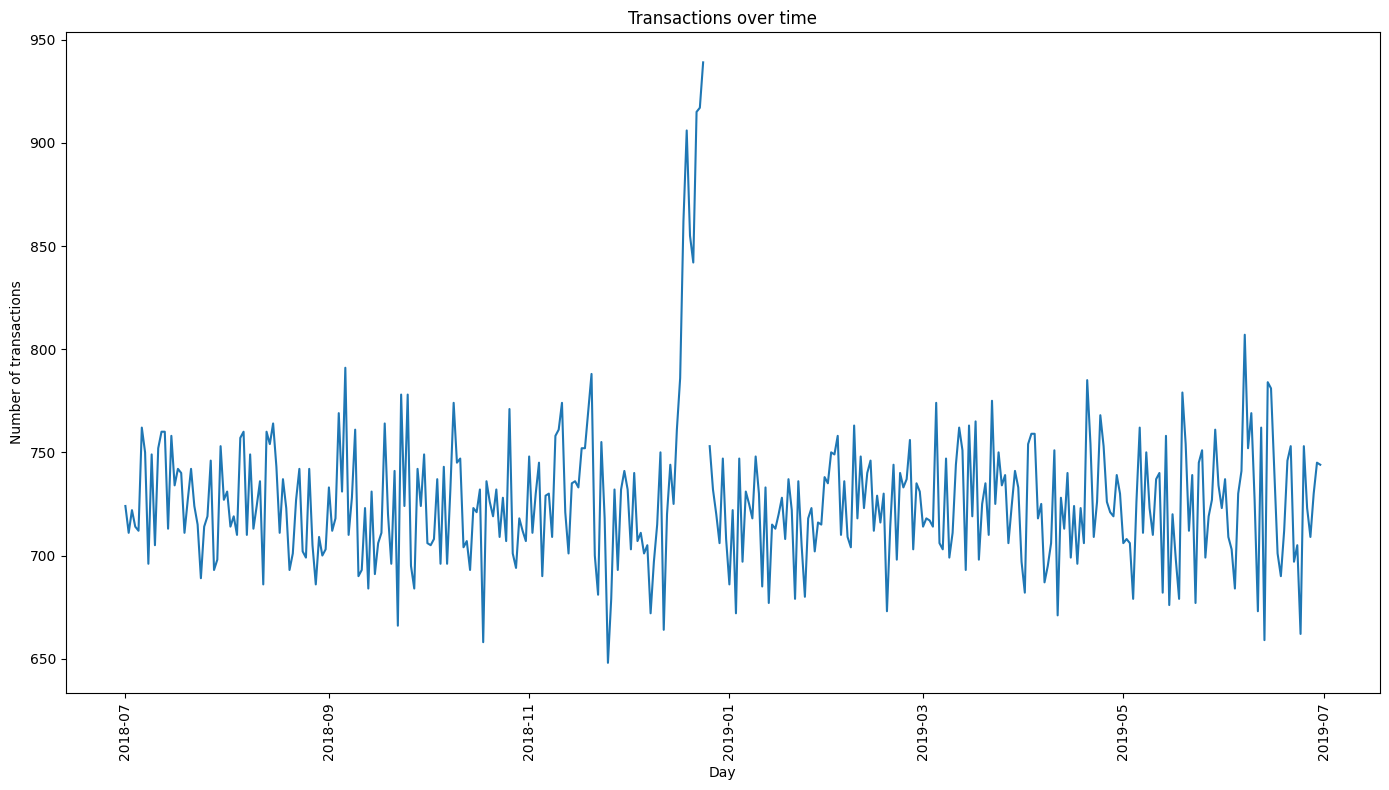

In [23]:
# Create full date sequence
full_dates = pd.DataFrame({
    "DATE": pd.date_range(start="2018-07-01", end="2019-06-30", freq="D")
})

# Merge with transaction counts
transactions_by_day = full_dates.merge(
    transactions_per_date, on="DATE", how="left"
)

plt.figure(figsize=(14, 8))
plt.plot(transactions_by_day["DATE"], transactions_by_day["TRANSACTION_COUNT"])
plt.title("Transactions over time")
plt.xlabel("Day")
plt.ylabel("Number of transactions")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We can see that there is an increase in purchases in December and a break in late December. Let’s zoom in on this.

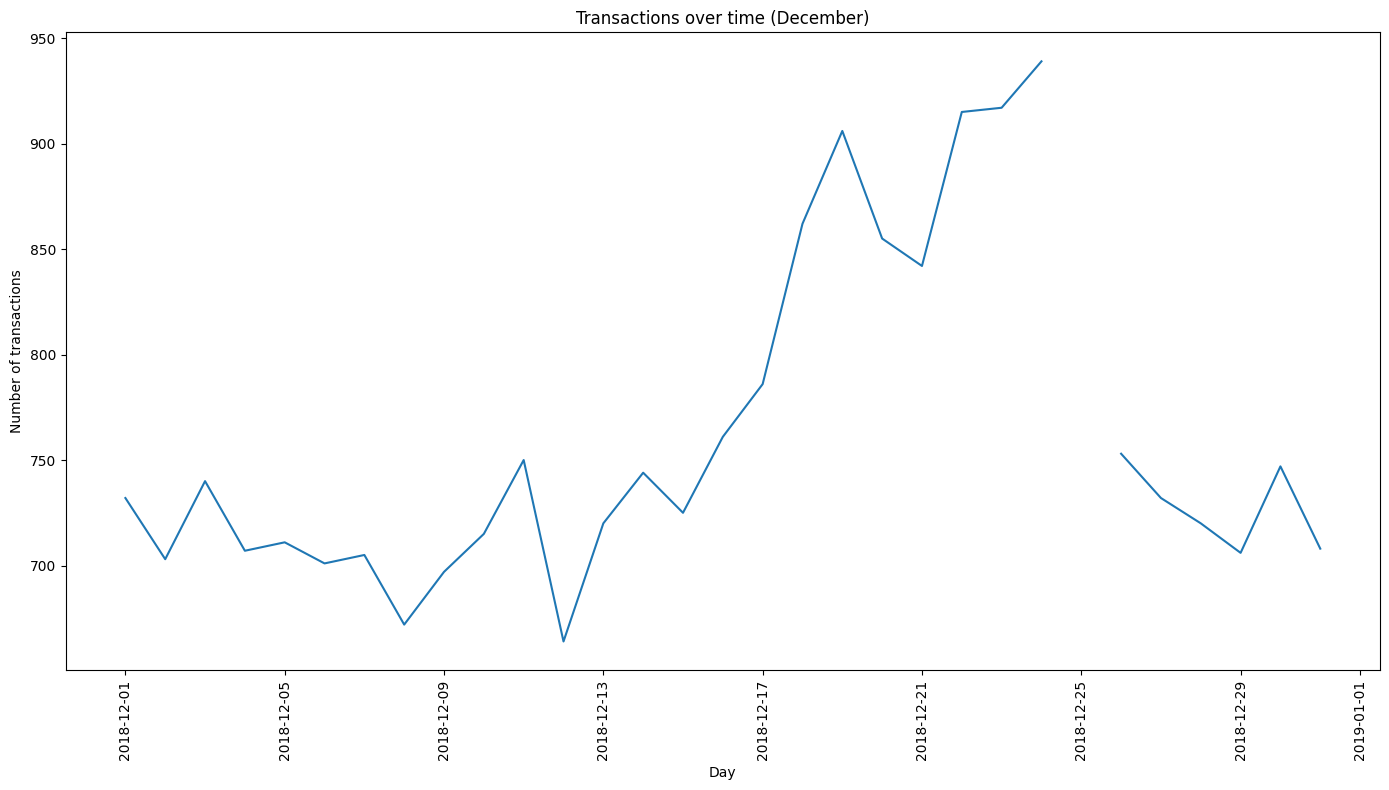

In [25]:
# Filter to December (month = 12)
dec_data = transactions_by_day[transactions_by_day["DATE"].dt.month == 12]

# Plot
plt.figure(figsize=(14, 8))
plt.plot(dec_data["DATE"], dec_data["TRANSACTION_COUNT"])

plt.title("Transactions over time (December)")
plt.xlabel("Day")
plt.ylabel("Number of transactions")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

We can see that the increase in sales occurs in the lead-up to Christmas and that there are zero sales on Christmas day itself. This is due to shops being closed on Christmas day.

Now that we are satisfied that the data no longer has outliers, we can move on to creating other features such as brand of chips or pack size from PROD_NAME. We will start with pack size.

In [26]:
transactions_clean["PACK_SIZE"] = (
    transactions_clean["PROD_NAME"]
        .str.extract(r"(\d+)", expand=False)   # extract first number
        .astype(float)                         # convert to numeric
)

In [27]:
pack_size_counts = (
    transactions_clean
        .groupby("PACK_SIZE")
        .size()
        .reset_index(name="N")
        .sort_values("PACK_SIZE")
)

pack_size_counts.head()

,PACK_SIZE,N
0,70.0,1507
1,90.0,3008
2,110.0,22387
3,125.0,1454
4,134.0,25102


In [28]:
transactions_clean["PACK_SIZE"].describe()

count    264833.000000
mean        182.425540
std          64.325268
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: PACK_SIZE, dtype: float64

The largest size is 380g and the smallest size is 70g - seems sensible!

In [29]:
transactions_clean.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0


Let's plot a histogram of PACK_SIZE since we know that it is a categorical variable and not a continuous variable even though it is numeric.

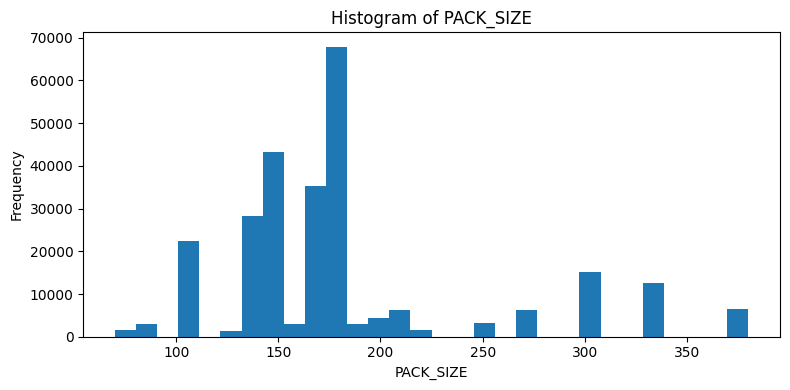

In [30]:
plt.figure(figsize=(8,4))
plt.hist(transactions_clean["PACK_SIZE"].dropna(), bins=30)

plt.title("Histogram of PACK_SIZE")
plt.xlabel("PACK_SIZE")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Pack sizes created look reasonable and now to create brands, we can use the first word in PROD_NAME to work out the brand name

Extract BRAND (uppercase first word)

In [31]:
transactions_clean["BRAND"] = (
    transactions_clean["PROD_NAME"]
        .str.split().str[0]        # first word
        .str.upper()               # uppercase
)

Count rows per BRAND

In [32]:
brand_counts = (
    transactions_clean
        .groupby("BRAND")
        .size()
        .reset_index(name="N")
        .sort_values("N", ascending=False)
)

brand_counts.head()

,BRAND,N
12,KETTLE,41288
20,SMITHS,28859
16,PRINGLES,25102
6,DORITOS,24962
23,THINS,14075


In [33]:
sorted(transactions_clean["BRAND"].unique())

['BURGER',
 'CCS',
 'CHEETOS',
 'CHEEZELS',
 'COBS',
 'DORITO',
 'DORITOS',
 'FRENCH',
 'GRAIN',
 'GRNWVES',
 'INFUZIONS',
 'INFZNS',
 'KETTLE',
 'NATURAL',
 'NCC',
 'OLD',
 'PRINGLES',
 'RED',
 'RRD',
 'SMITH',
 'SMITHS',
 'SNBTS',
 'SUNBITES',
 'THINS',
 'TOSTITOS',
 'TWISTIES',
 'TYRRELLS',
 'WOOLWORTHS',
 'WW']

Some of the brand names look like they are of the same brands - such as RED and RRD, which are both Red Rock Deli chips. Let’s combine these together.

In [34]:
brand_mapping = {
    "RED": "RRD",
    "SNBTS": "SUNBITES",
    "INFZNS": "INFUZIONS",
    "WW": "WOOLWORTHS",
    "SMITH": "SMITHS",
    "NCC": "NATURAL",
    "DORITO": "DORITOS",
    "GRAIN": "GRNWVES"
}

transactions_clean["BRAND"] = transactions_clean["BRAND"].replace(brand_mapping)

In [35]:
sorted(transactions_clean["BRAND"].unique())

['BURGER',
 'CCS',
 'CHEETOS',
 'CHEEZELS',
 'COBS',
 'DORITOS',
 'FRENCH',
 'GRNWVES',
 'INFUZIONS',
 'KETTLE',
 'NATURAL',
 'OLD',
 'PRINGLES',
 'RRD',
 'SMITHS',
 'SUNBITES',
 'THINS',
 'TOSTITOS',
 'TWISTIES',
 'TYRRELLS',
 'WOOLWORTHS']

## 2. Examine Customer Data and Merge

Goal:
- Check data types, missing values, and duplicates in customer data  
- Make sure `LYLTY_CARD_NBR` looks correct  
- Merge transactions and customer tables on `LYLTY_CARD_NBR`  
- Save the merged dataset

**Explore customers**

**Output Interpretation:**
- **Total Sales**: $1,933,109 - total revenue from all chip sales
- **Number of Transactions**: 263,125 unique transactions
- **Number of Customers**: 72,636 unique customers
- These are our baseline metrics for the analysis period


In [40]:
print("Customer shape:", customers.shape)
print("\nCustomer dtypes:")
print(customers.dtypes)

print("\nMissing values per column:")
print(customers.isna().sum())

print("\nDuplicate rows:", customers.duplicated().sum())

customers.head()

Customer shape: (72637, 3)

Customer dtypes:
LYLTY_CARD_NBR       int64
LIFESTAGE           object
PREMIUM_CUSTOMER    object
dtype: object

Missing values per column:
LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

Duplicate rows: 0


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


**Merge on LYLTY_CARD_NBR**

In [41]:
data = transactions_clean.merge(
    customers,
    on="LYLTY_CARD_NBR",
    how="left"   # keep all transactions, attach customer info
)

print("Merged shape:", data.shape)
data.head()


Merged shape: (264833, 12)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,KETTLE,MIDAGE SINGLES/COUPLES,Budget


**Check merge success (no missing segments)**

In [42]:
if "LIFESTAGE" in data.columns:
    print("Missing LIFESTAGE:", data["LIFESTAGE"].isna().sum())
if "PREMIUM_CUSTOMER" in data.columns:
    print("Missing PREMIUM_CUSTOMER:", data["PREMIUM_CUSTOMER"].isna().sum())

Missing LIFESTAGE: 0
Missing PREMIUM_CUSTOMER: 0


## 3. Data Analysis and Customer Segments

In this section you will:

- Calculate total sales and number of customers  
- Find which stores and products drive sales  
- Look at sales by customer `LIFESTAGE` and `PREMIUM_CUSTOMER`  
- Create charts to visualise sales patterns

**Core metrics**

In [43]:
total_sales = data["TOT_SALES"].sum()
num_transactions = data["TXN_ID"].nunique()
num_customers = data["LYLTY_CARD_NBR"].nunique()

print("Total Sales:", total_sales)
print("Number of Transactions:", num_transactions)
print("Number of Customers:", num_customers)


Total Sales: 1933109.0
Number of Transactions: 263125
Number of Customers: 72636


**Sales by store**

In [44]:
sales_by_store = (
    data.groupby("STORE_NBR")["TOT_SALES"]
    .sum()
    .sort_values(ascending=False)
)

sales_by_store.head()

STORE_NBR
226    17605.45
88     16333.25
165    15973.75
40     15559.50
237    15539.50
Name: TOT_SALES, dtype: float64

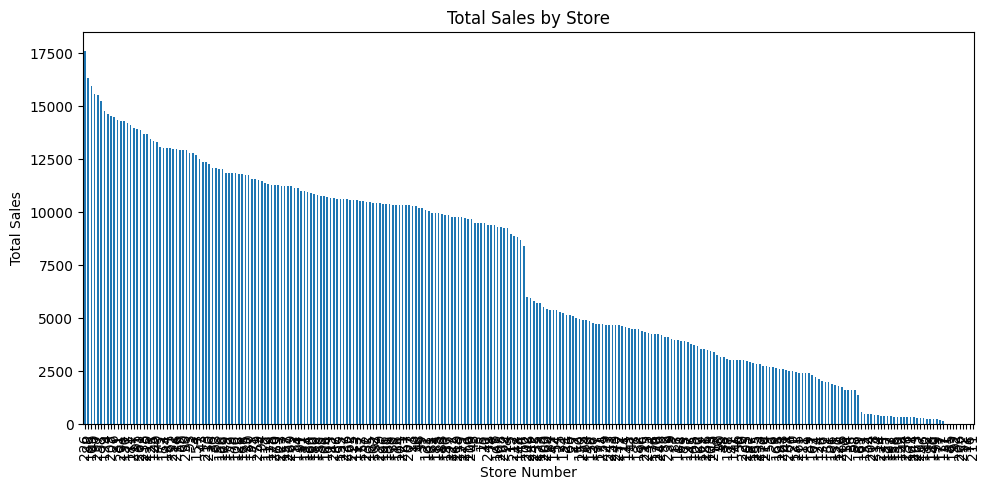

In [45]:
plt.figure(figsize=(10,5))
sales_by_store.plot(kind="bar")
plt.title("Total Sales by Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

**Sales by product**

In [46]:
sales_by_product = (
    data.groupby("PROD_NAME")["TOT_SALES"]
    .sum()
    .sort_values(ascending=False)
)

top_products = sales_by_product.head(10)
top_products

PROD_NAME
Dorito Corn Chp     Supreme 380g            39052.0
Smiths Crnkle Chip  Orgnl Big Bag 380g      36367.6
Smiths Crinkle Chips Salt & Vinegar 330g    34804.2
Kettle Mozzarella   Basil & Pesto 175g      34457.4
Smiths Crinkle      Original 330g           34302.6
Cheezels Cheese 330g                        34296.9
Doritos Cheese      Supreme 330g            33390.6
Kettle Sweet Chilli And Sour Cream 175g     33031.8
Kettle Original 175g                        32740.2
Kettle Sea Salt     And Vinegar 175g        32589.0
Name: TOT_SALES, dtype: float64

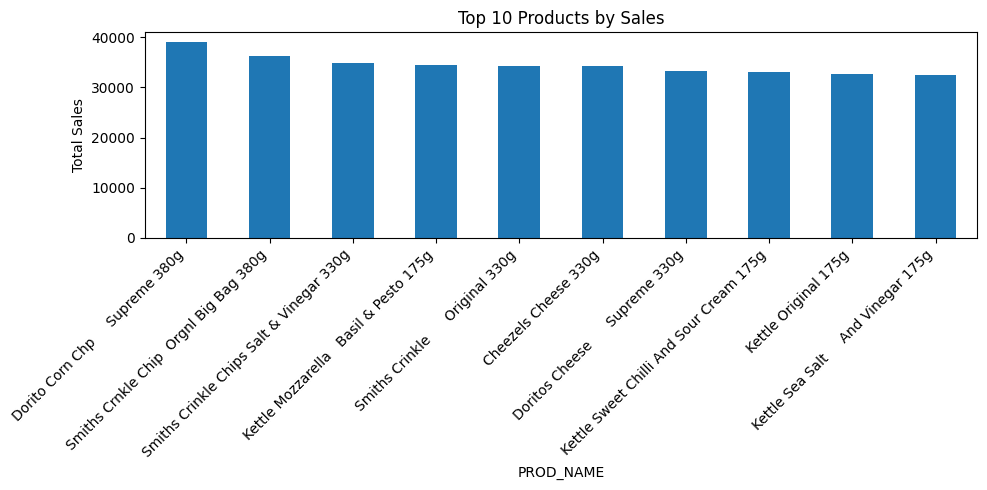

In [47]:
plt.figure(figsize=(10,5))
top_products.plot(kind="bar")
plt.title("Top 10 Products by Sales")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


**Sales over time**

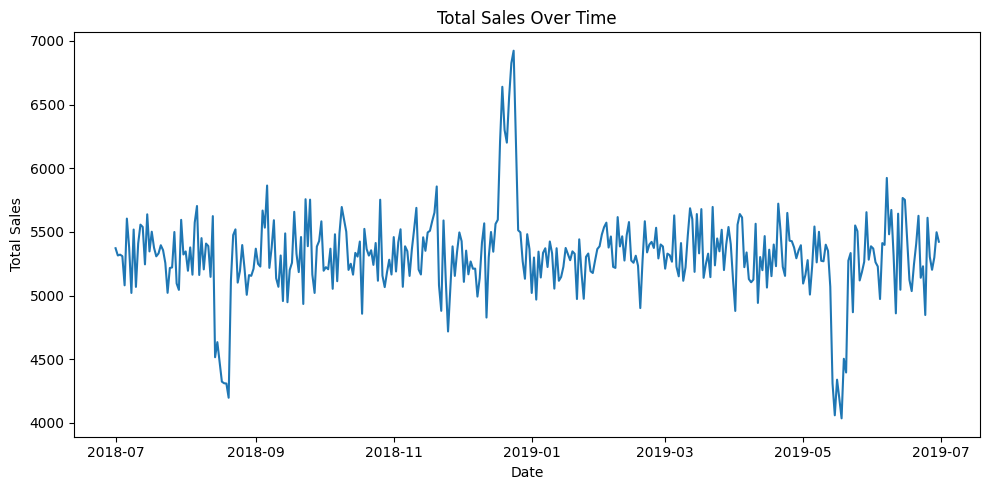

In [48]:
sales_by_date = (
    data.groupby("DATE")["TOT_SALES"]
    .sum()
    .reset_index()
    .sort_values("DATE")
)

plt.figure(figsize=(10,5))
plt.plot(sales_by_date["DATE"], sales_by_date["TOT_SALES"])
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

**Sales by segment (LIFESTAGE & PREMIUM_CUSTOMER)**

In [49]:
if {"LIFESTAGE", "PREMIUM_CUSTOMER"}.issubset(data.columns):
    sales_seg = (
        data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"]
        .sum()
        .reset_index()
        .sort_values("TOT_SALES", ascending=False)
    )
    sales_seg

<Figure size 1200x500 with 0 Axes>

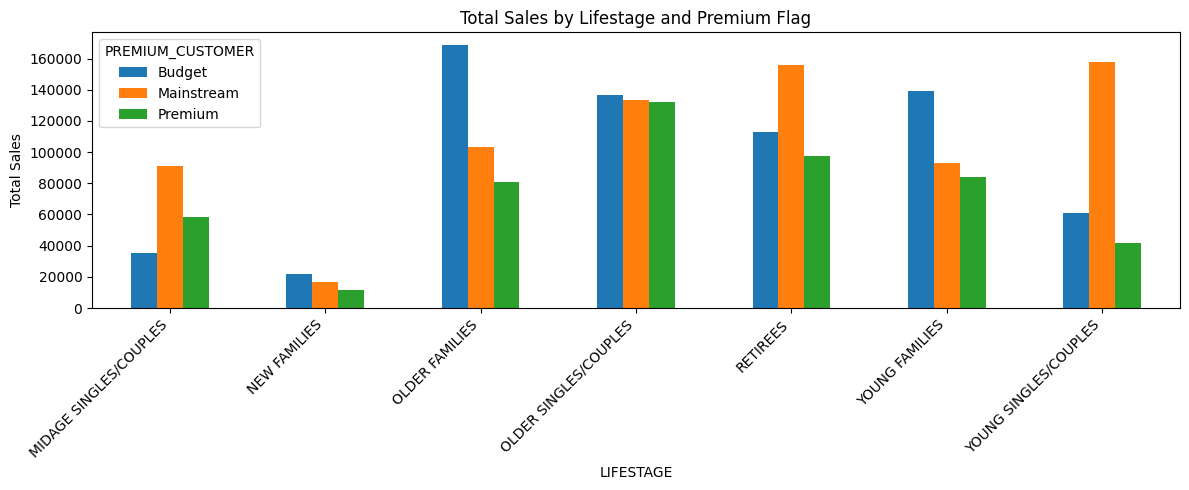

In [50]:
if "sales_seg" in locals():
    plt.figure(figsize=(12,5))
    pivot_seg = sales_seg.pivot(
        index="LIFESTAGE", columns="PREMIUM_CUSTOMER", values="TOT_SALES"
    )
    pivot_seg.plot(kind="bar", figsize=(12,5))
    plt.title("Total Sales by Lifestage and Premium Flag")
    plt.ylabel("Total Sales")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

## 4. Deep Dive into Customer Segments

Now we:

- Look at **units per customer** per segment  
- Look at **average price per unit** per segment  
- Define which segments we recommend targeting  
- Check if **pack size (packet size)** is important

**Units per customer (by LIFESTAGE & PREMIUM_CUSTOMER)**

In [51]:
if {"LIFESTAGE", "PREMIUM_CUSTOMER"}.issubset(data.columns):
    avg_units = (
        data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])
        .agg(
            total_qty=("PROD_QTY", "sum"),
            customers=("LYLTY_CARD_NBR", "nunique")
        )
        .assign(avg_units_per_customer=lambda d: d["total_qty"] / d["customers"])
        .reset_index()
        .sort_values("avg_units_per_customer", ascending=False)
    )
    avg_units

<Figure size 1200x500 with 0 Axes>

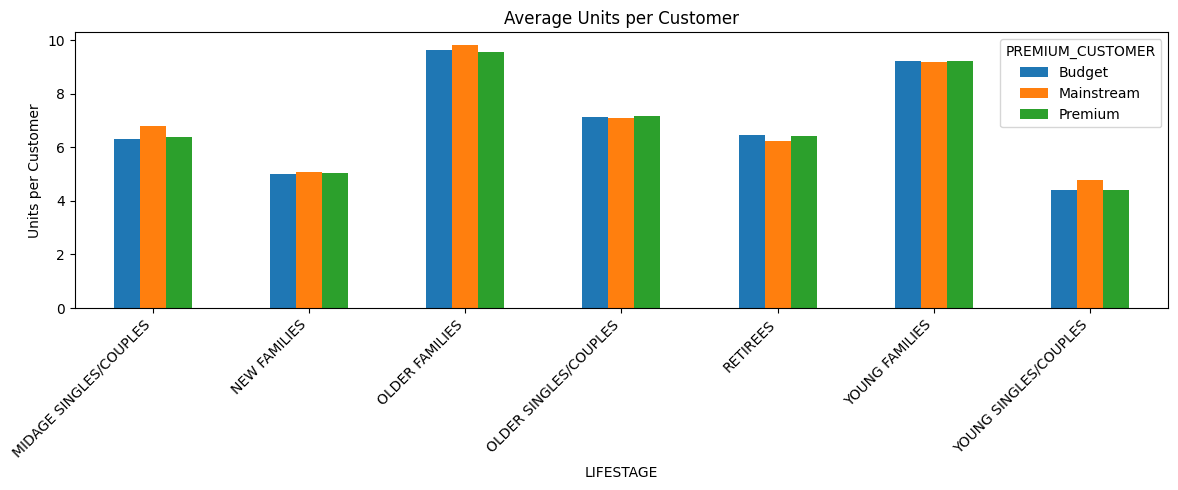

In [52]:
if "avg_units" in locals():
    plt.figure(figsize=(12,5))
    pivot_units = avg_units.pivot(
        index="LIFESTAGE",
        columns="PREMIUM_CUSTOMER",
        values="avg_units_per_customer"
    )
    pivot_units.plot(kind="bar", figsize=(12,5))
    plt.title("Average Units per Customer")
    plt.ylabel("Units per Customer")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

**Average price per unit per segment**

In [53]:
data["PRICE_PER_UNIT"] = data["TOT_SALES"] / data["PROD_QTY"]

avg_price = (
    data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PRICE_PER_UNIT"]
    .mean()
    .reset_index()
    .sort_values("PRICE_PER_UNIT", ascending=False)
)
avg_price

,LIFESTAGE,PREMIUM_CUSTOMER,PRICE_PER_UNIT
19,YOUNG SINGLES/COUPLES,Mainstream,4.071485
1,MIDAGE SINGLES/COUPLES,Mainstream,4.000101
12,RETIREES,Budget,3.924883
14,RETIREES,Premium,3.921323
3,NEW FAMILIES,Budget,3.919251
4,NEW FAMILIES,Mainstream,3.916581
11,OLDER SINGLES/COUPLES,Premium,3.887270
9,OLDER SINGLES/COUPLES,Budget,3.877022
5,NEW FAMILIES,Premium,3.871743
13,RETIREES,Mainstream,3.833343


<Figure size 1200x500 with 0 Axes>

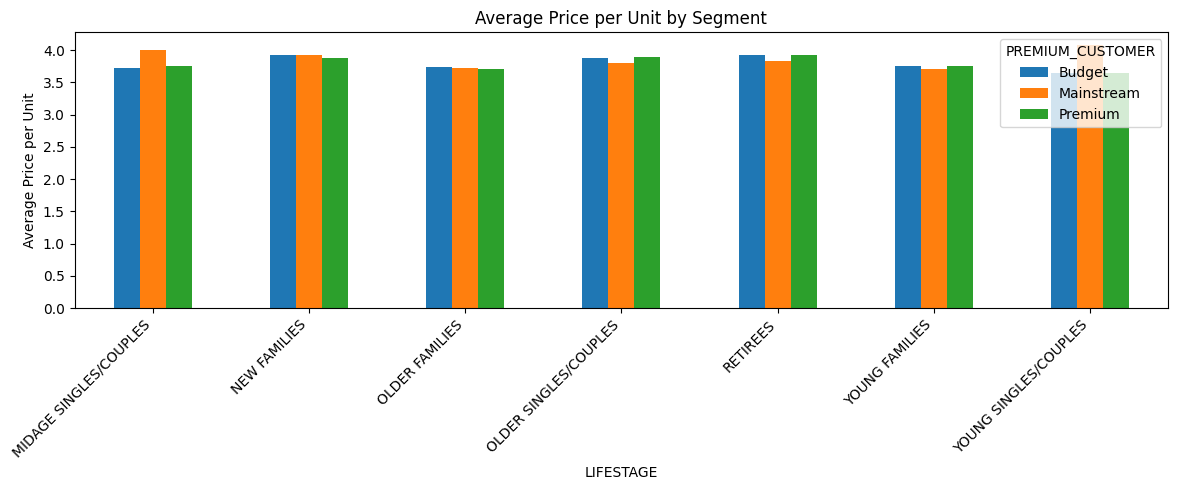

In [54]:
plt.figure(figsize=(12,5))
pivot_price = avg_price.pivot(
    index="LIFESTAGE", columns="PREMIUM_CUSTOMER", values="PRICE_PER_UNIT"
)
pivot_price.plot(kind="bar", figsize=(12,5))
plt.title("Average Price per Unit by Segment")
plt.ylabel("Average Price per Unit")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Extract PACK_SIZE from PROD_NAME (packet sizes)**

In [55]:
def extract_pack_size(name):
    match = re.search(r"(\d+)\s*[gG]", str(name))
    if match:
        return int(match.group(1))
    return np.nan

data["PACK_SIZE"] = data["PROD_NAME"].apply(extract_pack_size)

data["PACK_SIZE"].describe()

count    264833.000000
mean        182.425540
std          64.325268
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: PACK_SIZE, dtype: float64

**Average pack size by segment**

In [56]:
pack_by_segment = (
    data.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PACK_SIZE"]
    .mean()
    .reset_index()
    .sort_values("PACK_SIZE", ascending=False)
)
pack_by_segment

,LIFESTAGE,PREMIUM_CUSTOMER,PACK_SIZE
19,YOUNG SINGLES/COUPLES,Mainstream,184.828330
1,MIDAGE SINGLES/COUPLES,Mainstream,184.582786
11,OLDER SINGLES/COUPLES,Premium,183.254999
14,RETIREES,Premium,182.975260
12,RETIREES,Budget,182.960200
15,YOUNG FAMILIES,Budget,182.490901
6,OLDER FAMILIES,Budget,182.487219
9,OLDER SINGLES/COUPLES,Budget,182.289183
13,RETIREES,Mainstream,182.289062
7,OLDER FAMILIES,Mainstream,182.175021


<Figure size 1200x500 with 0 Axes>

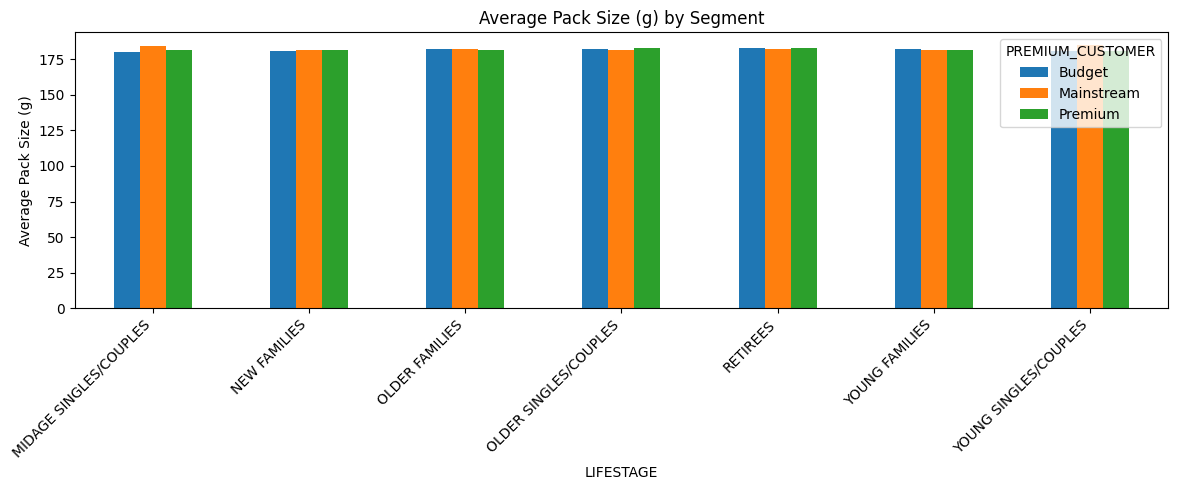

In [57]:
plt.figure(figsize=(12,5))
pivot_pack = pack_by_segment.pivot(
    index="LIFESTAGE", columns="PREMIUM_CUSTOMER", values="PACK_SIZE"
)
pivot_pack.plot(kind="bar", figsize=(12,5))
plt.title("Average Pack Size (g) by Segment")
plt.ylabel("Average Pack Size (g)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()